In [145]:
import numpy as np
import numba as nb
from scipy.stats import maxwell
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy
from matplotlib.widgets import Slider

# Periodic boundary conditions
# Rabbits are field with positions, velocities, awareness radius.
NVAR = 5
PVAR = NVAR-1
N = 50
R = 0.15
GA = 0.2
RA = 10
PA = 1/30
dt = 0.01
ms = 5
PRED_NOISE = 0.02
RADIUS_PRED = 0.2
Niterations = 100
MAX_SPEED = 0.01/dt
PRED_SPEED = MAX_SPEED #NEW
DECAY_RATE = 0.995

In [151]:
#@nb.njit
def init_rabbits(N, NVAR):
    # Velocities and positions
    rabbits = np.zeros((N, NVAR))

    positions = np.random.rand(N, 2)
    rabbits[:, 0:2] = positions
    
    velocities = 0#T * (np.random.rand(N, 2) - 1/2)
    rabbits[:, 2:4] = velocities
    
    return rabbits

def init_nn_array(N):
    return np.zeros((N, N - 1))

@nb.njit
def get_rn_noise(amplitude):
    
    # Random walk
    N = len(rabbits)
    perturbation = amplitude * (np.random.rand(N, 2) - 0.5)
    return perturbation

In [217]:
from scipy.spatial import distance

def closest_node(node, nodes):
    """https://codereview.stackexchange.com/questions/28207/finding-the-closest-point-to-a-list-of-points"""
    return distance.cdist([node[:2]], nodes[:,:2]).argmin()

def get_closest_other(rabbits,predators):
    """Get closest rabbit-predator pair"""
    return np.apply_along_axis(closest_node, 1, rabbits, predators)

In [218]:
def init_predators(N,PVAR):
    # Velocities and positions
    predators = np.zeros((N, PVAR))

    positions = np.random.rand(N, 2)
    predators[:, 0:2] = positions
    
    velocities = np.random.rand(N, 2)
    predators[:, 2:4] = velocities
    
    return predators

In [219]:
def predator_force(zero, distances, RADIUS_PRED, PA):
    mask = np.linalg.norm(zero[:4] - distances) > RADIUS_PRED
    distances[mask] = np.inf
    return PA/distances

def get_predators_force(rabbits, predators, PA):
    return np.apply_along_axis(predator_force, 1, rabbits, predators, RADIUS_PRED,PA).sum(axis=1)[:,2:4]

In [220]:
get_predators_force(rabbits, predators, PA).shape

(50, 2)

In [221]:
rabbits = init_rabbits(N, NVAR)
predators = init_predators(3, PVAR)

In [222]:
rabbits.shape,predators.shape

((50, 5), (3, 4))

In [223]:
get_closest_other(rabbits[:,:4],predators)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 2, 2, 0, 2, 0, 0,
       2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 0, 1, 0, 2, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1])

(50, 2)


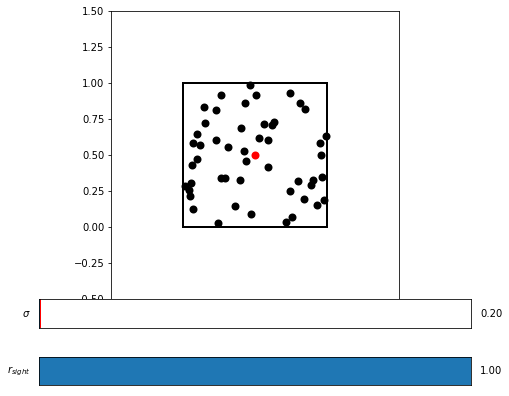

In [224]:
def update_velocities(dt):
    
    # Rabbits
    nn = get_nn(R)
    group_force = get_group_influence(GA, nn)
    perturbation = get_rn_noise(RA)
    predators_force = get_predators_force(rabbits, predators, PA)
    print(perturbation.shape)
    rabbits[:, 2:4] += dt * (group_force + perturbation + predators_force) 
    rabbits[:, 2:4] *= DECAY_RATE

    for rabbit in rabbits:
        v = np.linalg.norm(rabbit[2:4])
        if v > MAX_SPEED:
            rabbit[2:4] = rabbit[2:4] * MAX_SPEED/ v
    
    # Predator
    closest_rabbits = get_closest_other(predators,rabbits) #IDK how to normalize properly
    predators[:, 2:4] = PRED_SPEED*(rabbits[closest_rabbits][:,:2]/np.linalg.norm(rabbits[closest_rabbits][:,:2],axis=1)[:,None]**2)
    predators[:, 2:4] += PRED_NOISE * (np.random.rand(2) - 0.5)
    
def step(dt):
    update_velocities(dt)
    
    rabbits[:, 0] = (rabbits[:, 0] + dt * rabbits[:, 2]) % 1
    rabbits[:, 1] = (rabbits[:, 1] + dt * rabbits[:, 3]) % 1
    
    predators[:, 0] = (predators[:, 0] + dt * predators[:, 2]) % 1
    predators[:, 1] = (predators[:, 1] + dt * predators[:, 3]) % 1
    return rabbits

def get_nn(r):
    """
    Returns array nn_indices, where the N-th elements contains the indices of the N-th rabbit
    
    shape nn_indices = N
    """
    
    # Clean arrays
    nn_array[:, :] = -1
    combination_array[:, :] = 0
    nn_indices[:] = 0
    
    # For loop has O(N^@)
    for i, rabbit in enumerate(rabbits):
        for j, rabbit_n in enumerate(rabbits):
            # Remove self-interaction
            if i != j:
                # Remove redundant calculations
                if combination_array[i, j] != 1:
                    combination_array[i, j] = 1
                    combination_array[j , i] = 1
                    # Possible new swarm interaction
                    d = np.linalg.norm(rabbit[0:2] - rabbit_n[0:2])
                    if d < r:
                        nn_array[i, nn_indices[i], 0] = j
                        nn_array[j, nn_indices[j], 0] = i
                        nn_array[i, nn_indices[i], 1] = d
                        nn_array[j, nn_indices[j], 1] = d
                        nn_indices[i] += 1
                        nn_indices[j] += 1
                        
    return nn_array


def animatePeriodic(i):
    
    global RADIUS_PRED, RA
    RA = s_w.val
    RADIUS_PRED = s_r.val
    step(dt)
    rect.set_edgecolor('k')
    fields[0].set_offsets(rabbits[:, 0:2])
    fields[1].set_offsets(predator[0:2])
    return fields


#@nb.njit
def get_group_influence(amplitude, nn):
    """Given the nearest neighbor array, calculates the swarm influence 

    Parameters
    ----------
    rabits : float array
        Array containing all values of positions and velocities of the rabbits.
    nn_array : int, float array
        Array where N-th elements contains the indices combined with distances to nearest neighbors.

    Returns
    -------
    float array
        N, 2 float array which describes the force caused by the group
    """
    
    # TODO Add weighted sums (closer neighbors have more influence)
    #total_weights = np.zeros((N))
    
    
    group_velocities = np.zeros((N, 2))
    
    # Collect weights
    #for i, rabbit in enumerate(nn):
    #    total_weights[i] = np.sum(rabbit[:, 0])
    
    temp_vel = np.zeros((2))
    # Calculate the average velocity vector of neighbors weighed proportionally to their distance
    for i, rabbit in enumerate(nn):
        # No neighbors
        #if total_weights[i] == 0:
            #break
        
        temp_vel[:] = 0
        for neighbor in rabbit:
            if neighbor[0] == -1:
                break
            else:
                # Neighbor 0 is index
                # Neighbor 1 is distance
                temp_vel += rabbits[neighbor[0], 2:4]
        #temp_vel /= total_weights[i]
        # TODO MIGHT NEED TO ADD COPY AGAIN
        group_velocities[i] = temp_vel
        temp_vel[:] = 0
        
    return amplitude * group_velocities          
            
        
if __name__ == '__main__':
    rabbits = init_rabbits(N, NVAR)
    predators = init_predators(3, PVAR)
    nn_array = np.zeros((N, N, 2), dtype = np.int)
    combination_array = np.zeros((N, N), dtype = np.int)
    nn_indices = np.zeros((N), dtype = np.int)
    
    plotlays, plotcols = [2], ["black","red"]
    
    fig = plt.figure()
    
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                        xlim=(-0.5, 1.5), ylim=(-0.5, 1.5))
    line, = ax.plot([], [], lw=2)
    # field holds the locations of the field
    fields = []
    for index in range(2):
        lobj = ax.scatter([],[],lw=2,color=plotcols[index])
        fields.append(lobj)
        
    rect = plt.Rectangle([0,0],1,1,
                        ec='none', lw=2, fc='none')
    ax.add_patch(rect)
    
    # ADD SLIDERS
    ax_w = plt.axes([0, -0.3, 1, 0.1])#, facecolor=axcolor)
    ax_r = plt.axes([0, -0.1, 1, 0.1])#, facecolor=axcolor)

    s_w = a_slider = Slider(ax_w,      # the axes object containing the slider
                  r'$r_{sight}$',            # the name of the slider parameter
                  0.05,          # minimal value of the parameter
                  1,          # maximal value of the parameter
                  valinit=RADIUS_PRED  # initial value of the parameter
                 )

    s_r = a_slider = Slider(ax_r,      # the axes object containing the slider
                  r'$\sigma$',            # the name of the slider parameter
                  0,          # minimal value of the parameter
                  100,          # maximal value of the parameter
                  valinit=RA  # initial value of the parameter
                 )

    s_w.on_changed(animatePeriodic)
    s_r.on_changed(animatePeriodic)
    
    ani = animation.FuncAnimation(fig, animatePeriodic, frames=Niterations,
                                interval=1, blit=True)
    
    # Settings for save
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

#     ani.save('panic.mp4', writer=writer)
    plt.show()

(50, 2)


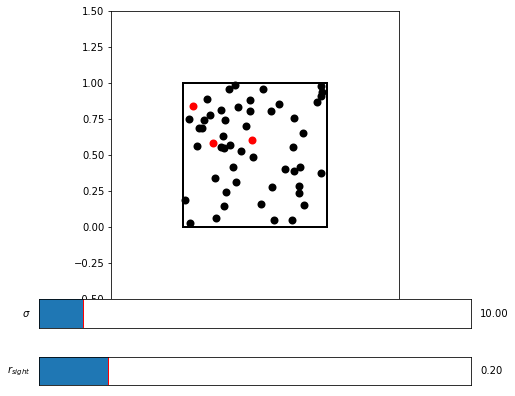

In [226]:
import numpy as np
from scipy.stats import maxwell
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy
from matplotlib.widgets import Slider

# Periodic boundary conditions
# Rabbits are field with positions, velocities, awareness radius.
NVAR = 5
PVAR = NVAR-1
N = 50
R = 0.15
GA = 0.2
RA = 10
PA = 1/30
dt = 0.01
ms = 5
PRED_NOISE = 0.02
RADIUS_PRED = 0.2
Niterations = 100
MAX_SPEED = 0.01/dt
PRED_SPEED = MAX_SPEED #NEW
DECAY_RATE = 0.995

#@nb.njit
def init_rabbits(N, NVAR):
    # Velocities and positions
    rabbits = np.zeros((N, NVAR))

    positions = np.random.rand(N, 2)
    rabbits[:, 0:2] = positions
    
    velocities = 0#T * (np.random.rand(N, 2) - 1/2)
    rabbits[:, 2:4] = velocities
    
    return rabbits

def init_nn_array(N):
    return np.zeros((N, N - 1))

# @nb.njit
def get_rn_noise(amplitude):
    
    # Random walk
    N = len(rabbits)
    perturbation = amplitude * (np.random.rand(N, 2) - 0.5)
    return perturbation

##NEW
from scipy.spatial import distance

def closest_node(node, nodes):
    """https://codereview.stackexchange.com/questions/28207/finding-the-closest-point-to-a-list-of-points"""
    return distance.cdist([node[:2]], nodes[:,:2]).argmin()

def get_closest_other(rabbits,predators):
    """Get closest rabbit-predator pair"""
    return np.apply_along_axis(closest_node, 1, rabbits, predators)

def init_predators(N,PVAR):
    # Velocities and positions
    predators = np.zeros((N, PVAR))

    positions = np.random.rand(N, 2)
    predators[:, 0:2] = positions
    
    velocities = np.random.rand(N, 2)
    predators[:, 2:4] = velocities
    
    return predators

def predator_force(zero, distances, RADIUS_PRED, PA):
    mask = np.linalg.norm(zero[:4] - distances) > RADIUS_PRED
    distances[mask] = np.inf
    return PA/distances

def get_predators_force(rabbits, predators, PA):
    return np.apply_along_axis(predator_force, 1, rabbits, predators, RADIUS_PRED,PA).sum(axis=1)[:,2:4]

##TIll here

def update_velocities(dt):
    
    # Rabbits
    nn = get_nn(R)
    group_force = get_group_influence(GA, nn)
    perturbation = get_rn_noise(RA)
    predators_force = get_predators_force(rabbits, predators, PA)
    print(perturbation.shape)
    rabbits[:, 2:4] += dt * (group_force + perturbation + predators_force) 
    rabbits[:, 2:4] *= DECAY_RATE

    for rabbit in rabbits:
        v = np.linalg.norm(rabbit[2:4])
        if v > MAX_SPEED:
            rabbit[2:4] = rabbit[2:4] * MAX_SPEED/ v
    
    # Predator
    closest_rabbits = get_closest_other(predators,rabbits) #IDK how to normalize properly
    predators[:, 2:4] = PRED_SPEED*(rabbits[closest_rabbits][:,:2]/np.linalg.norm(rabbits[closest_rabbits][:,:2],axis=1)[:,None]**2)
    predators[:, 2:4] += PRED_NOISE * (np.random.rand(2) - 0.5)
    
def step(dt):
    update_velocities(dt)
    
    rabbits[:, 0] = (rabbits[:, 0] + dt * rabbits[:, 2]) % 1
    rabbits[:, 1] = (rabbits[:, 1] + dt * rabbits[:, 3]) % 1
    
    predators[:, 0] = (predators[:, 0] + dt * predators[:, 2]) % 1
    predators[:, 1] = (predators[:, 1] + dt * predators[:, 3]) % 1
    return rabbits

def get_nn(r):
    """
    Returns array nn_indices, where the N-th elements contains the indices of the N-th rabbit
    
    shape nn_indices = N
    """
    
    # Clean arrays
    nn_array[:, :] = -1
    combination_array[:, :] = 0
    nn_indices[:] = 0
    
    # For loop has O(N^@)
    for i, rabbit in enumerate(rabbits):
        for j, rabbit_n in enumerate(rabbits):
            # Remove self-interaction
            if i != j:
                # Remove redundant calculations
                if combination_array[i, j] != 1:
                    combination_array[i, j] = 1
                    combination_array[j , i] = 1
                    # Possible new swarm interaction
                    d = np.linalg.norm(rabbit[0:2] - rabbit_n[0:2])
                    if d < r:
                        nn_array[i, nn_indices[i], 0] = j
                        nn_array[j, nn_indices[j], 0] = i
                        nn_array[i, nn_indices[i], 1] = d
                        nn_array[j, nn_indices[j], 1] = d
                        nn_indices[i] += 1
                        nn_indices[j] += 1
                        
    return nn_array


def animatePeriodic(i):
    
    global RADIUS_PRED, RA
    RA = s_w.val
    RADIUS_PRED = s_r.val
    step(dt)
    rect.set_edgecolor('k')
    fields[0].set_offsets(rabbits[:, 0:2])
    fields[1].set_offsets(predators[:,0:2])
    return fields


#@nb.njit
def get_group_influence(amplitude, nn):
    """Given the nearest neighbor array, calculates the swarm influence 

    Parameters
    ----------
    rabits : float array
        Array containing all values of positions and velocities of the rabbits.
    nn_array : int, float array
        Array where N-th elements contains the indices combined with distances to nearest neighbors.

    Returns
    -------
    float array
        N, 2 float array which describes the force caused by the group
    """
    
    # TODO Add weighted sums (closer neighbors have more influence)
    #total_weights = np.zeros((N))
    
    
    group_velocities = np.zeros((N, 2))
    
    # Collect weights
    #for i, rabbit in enumerate(nn):
    #    total_weights[i] = np.sum(rabbit[:, 0])
    
    temp_vel = np.zeros((2))
    # Calculate the average velocity vector of neighbors weighed proportionally to their distance
    for i, rabbit in enumerate(nn):
        # No neighbors
        #if total_weights[i] == 0:
            #break
        
        temp_vel[:] = 0
        for neighbor in rabbit:
            if neighbor[0] == -1:
                break
            else:
                # Neighbor 0 is index
                # Neighbor 1 is distance
                temp_vel += rabbits[neighbor[0], 2:4]
        #temp_vel /= total_weights[i]
        # TODO MIGHT NEED TO ADD COPY AGAIN
        group_velocities[i] = temp_vel
        temp_vel[:] = 0
        
    return amplitude * group_velocities          
            
        
if __name__ == '__main__':
    rabbits = init_rabbits(N, NVAR)
    predators = init_predators(3, PVAR)
    nn_array = np.zeros((N, N, 2), dtype = np.int)
    combination_array = np.zeros((N, N), dtype = np.int)
    nn_indices = np.zeros((N), dtype = np.int)
    
    plotlays, plotcols = [2], ["black","red"]
    
    fig = plt.figure()
    
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                        xlim=(-0.5, 1.5), ylim=(-0.5, 1.5))
    line, = ax.plot([], [], lw=2)
    # field holds the locations of the field
    fields = []
    for index in range(2):
        lobj = ax.scatter([],[],lw=2,color=plotcols[index])
        fields.append(lobj)
        
    rect = plt.Rectangle([0,0],1,1,
                        ec='none', lw=2, fc='none')
    ax.add_patch(rect)
    
    # ADD SLIDERS
    ax_w = plt.axes([0, -0.3, 1, 0.1])#, facecolor=axcolor)
    ax_r = plt.axes([0, -0.1, 1, 0.1])#, facecolor=axcolor)

    s_w = a_slider = Slider(ax_w,      # the axes object containing the slider
                  r'$r_{sight}$',            # the name of the slider parameter
                  0.05,          # minimal value of the parameter
                  1,          # maximal value of the parameter
                  valinit=RADIUS_PRED  # initial value of the parameter
                 )

    s_r = a_slider = Slider(ax_r,      # the axes object containing the slider
                  r'$\sigma$',            # the name of the slider parameter
                  0,          # minimal value of the parameter
                  100,          # maximal value of the parameter
                  valinit=RA  # initial value of the parameter
                 )

    s_w.on_changed(animatePeriodic)
    s_r.on_changed(animatePeriodic)
    
    ani = animation.FuncAnimation(fig, animatePeriodic, frames=Niterations,
                                interval=1, blit=True)
 
    # Settings for save
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

#     ani.save('panic.mp4', writer=writer)
    plt.show()